# ENSF 544 Project 2 - ASL alphabet Recognition Using Random Forest

### Importing Dependencies

In [ ]:
!pip install mediapipe
import os.path
import cv2 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import mediapipe as mp
import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/Y/Y190.jpg  
  inflating: asl_alphabet_train/Y/Y1900.jpg  
  inflating: asl_alphabet_train/Y/Y1901.jpg  
  inflating: asl_alphabet_train/Y/Y1902.jpg  
  inflating: asl_alphabet_train/Y/Y1903.jpg  
  inflating: asl_alphabet_train/Y/Y1904.jpg  
  inflating: asl_alphabet_train/Y/Y1905.jpg  
  inflating: asl_alphabet_train/Y/Y1906.jpg  
  inflating: asl_alphabet_train/Y/Y1907.jpg  
  inflating: asl_alphabet_train/Y/Y1908.jpg  
  inflating: asl_alphabet_train/Y/Y1909.jpg  
  inflating: asl_alphabet_train/Y/Y191.jpg  
  inflating: asl_alphabet_train/Y/Y1910.jpg  
  inflating: asl_alphabet_train/Y/Y1911.jpg  
  inflating: asl_alphabet_train/Y/Y1912.jpg  
  inflating: asl_alphabet_train/Y/Y1913.jpg  
  inflating: asl_alphabet_train/Y/Y1914.jpg  
  inflating: asl_alphabet_train/Y/Y1915.jpg  
  inflating: asl_alphabet_train/Y/Y1916.jpg  
  inflating: asl_alphabet_train/Y/Y1917.jpg  
  inflating: asl_alphabet_train

In [34]:
# The 21 Coordinates used for the RandomForestClassifier
# Each Coordinate contains 3 points: x, y, and z
len(mp.solutions.hands.HandLandmark)

21

### Pre-processing Functions

In [35]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

# LOAD function
def load_hand_landmark_data(directory, num_imgs_per_component=100, complexity=1, min_confidence=0.5):
    hand_landmarks = pd.DataFrame(columns= [e.name for e in mp.solutions.hands.HandLandmark] )
    labels = []

    plt.figure(figsize=(5,6))
    i = 1

    none_list = [0 for i in range(hand_landmarks.shape[1])]

    with mp_hands.Hands(
        static_image_mode = True,
        max_num_hands = 1,
        model_complexity = complexity,
        min_detection_confidence = min_confidence
        ) as hands:

        # Iterate through each image in each subfolder
        for folder in os.listdir(directory):
            if folder == '.DS_Store':
              continue
            image_count = 0
            for image in os.listdir(directory + "/" + folder):
                if image_count == num_imgs_per_component: 
                    break

                temp_img = cv2.imread(directory + '/' + folder + '/' + image)
                if temp_img is None: 
                    continue
                temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)

                ## result holds the 21 points
                result = hands.process(temp_img)
                # if api was not able to find a hand
                if not result.multi_hand_landmarks:
                  # fill with nothing (row of 0's)
                    last_landmark = None
                    hand_landmarks.loc[len(hand_landmarks)] = none_list
                else:
                  # hand found, call the function to process points
                    last_landmark = result.multi_hand_landmarks[0]
                    hand_landmarks.loc[len(hand_landmarks)] = list(result.multi_hand_landmarks[0].landmark)
                
                image_count += 1
                labels.append(folder)

            # displaying the last image of each letter
            # annotated_image = temp_img.copy()
            # if last_landmark:
            #     mp_drawing.draw_landmarks(
            #         annotated_image,
            #         last_landmark,
            #         mp_hands.HAND_CONNECTIONS,
            #         mp_drawing_styles.get_default_hand_landmarks_style(),
            #         mp_drawing_styles.get_default_hand_connections_style()
            #     )
            # plt.subplot(5, 6, i)
            # plt.title(folder)
            # plt.imshow(annotated_image)
            # plt.xticks([])
            # plt.yticks([])
            # i += 1

    # plt.show()
    return hand_landmarks, pd.Series(labels)


### Loading and Pre-processing Data

In [38]:
training_dir = "asl_alphabet_train"
test_dir = "asl_alphabet_test"

In [39]:
X_trainval, y_trainval = load_hand_landmark_data(training_dir, min_confidence=0.05)
orig_cols = X_trainval.columns


<Figure size 360x432 with 0 Axes>

In [40]:
# The pre processing functions:

# Rounding: Rounding the values to 3 decimal places
# def roundValues(row):
#   for cell in row:
#     cell = round(cell, 3)

def roundValues(cell):
  return round(cell, 3)

# Scaling: Multiply each coordinate by a scaling factor of 200 / L
#          Where L is the side length of the cubical bounding box
def scale_values_cubical(row, length_of_side):
  # scale values with 200 pixels
  if length_of_side == 0:
    return row
  scaling_factor = 200/length_of_side
  for cell in row:
    cell *= scaling_factor

  return row

# Shifting: X = x - xmin for each coorindate (x, y, z)
# Move down if this doesnt work
def shiftingValues(row):
  # values = []
  min_coords = find_min_coords(row)

  # index values:
  # 0 = x, 1 = y, 2 = z
  index = 0
  for i, v in row.items():
    v -= min_coords[index]
    index += 1
    if index > 2:
      index = 0
  
  return row

# Helper function: finds smallest coordinates
def find_min_coords(row):
  x_vals = []
  y_vals = []
  z_vals = []

  index = 0
  for cell in row:
    if index == 0:
      x_vals.append(cell)
    elif index == 1:
      y_vals.append(cell)
    elif index == 2:
      z_vals.append(cell)
    index += 1
    if index > 2:
      index = 0
    
  # determine min values
  xmin = min(x_vals)
  ymin = min(y_vals)
  zmin = min(z_vals)

  return [xmin, ymin, zmin]

# Helper function: finds largest coordinates
def find_max_coords(row):
  x_vals = []
  y_vals = []
  z_vals = []

  index = 0
  for cell in row:
    if index == 0:
      x_vals.append(cell)
    elif index == 1:
      y_vals.append(cell)
    elif index == 2:
      z_vals.append(cell)
    index += 1
    if index > 2:
      index = 0
    
  # determine max values
  xmax = max(x_vals)
  ymax = max(y_vals)
  zmax = max(z_vals)

  return [xmax, ymax, zmax]

def calculate_bounding_box(row, cuboid=False):

  min_coords = find_min_coords(row)
  max_coords = find_max_coords(row)

  # determine bounding cuboidal dimensions
  xlength = max_coords[0] - min_coords[0]
  ylength = max_coords[1] - min_coords[1]
  zlength = max_coords[2] - min_coords[2]

  cuboid_dimensions = [xlength, ylength, zlength]

  if cuboid:
    return cuboid_dimensions
  else:
    return max(cuboid_dimensions)

In [41]:
# This is how X_trainval looks before splitting each cell into
# its 3 respective coordinates
X_trainval

,WRIST,THUMB_CMC,THUMB_MCP,THUMB_IP,THUMB_TIP,INDEX_FINGER_MCP,INDEX_FINGER_PIP,INDEX_FINGER_DIP,INDEX_FINGER_TIP,MIDDLE_FINGER_MCP,...,MIDDLE_FINGER_DIP,MIDDLE_FINGER_TIP,RING_FINGER_MCP,RING_FINGER_PIP,RING_FINGER_DIP,RING_FINGER_TIP,PINKY_MCP,PINKY_PIP,PINKY_DIP,PINKY_TIP
0,x: 0.4370001554489136\ny: 0.9542551040649414\n...,x: 0.6090855002403259\ny: 0.9198281764984131\n...,x: 0.7602866888046265\ny: 0.8093404173851013\n...,x: 0.861669659614563\ny: 0.6921600699424744\nz...,x: 0.9259206652641296\ny: 0.5924868583679199\n...,x: 0.6221978068351746\ny: 0.5854527950286865\n...,x: 0.6183938980102539\ny: 0.40454840660095215\...,x: 0.5996584892272949\ny: 0.2922782301902771\n...,x: 0.5773022174835205\ny: 0.20158377289772034\...,x: 0.5177502632141113\ny: 0.5838629603385925\n...,...,x: 0.5189364552497864\ny: 0.6260324120521545\n...,x: 0.5232337117195129\ny: 0.7372063398361206\n...,x: 0.4145934581756592\ny: 0.6139349937438965\n...,x: 0.4199444055557251\ny: 0.5023142695426941\n...,x: 0.4278334975242615\ny: 0.6556887030601501\n...,x: 0.4340338110923767\ny: 0.7581520080566406\n...,x: 0.30850955843925476\ny: 0.6637623310089111\...,x: 0.3237368166446686\ny: 0.5776060223579407\n...,x: 0.3509212136268616\ny: 0.6900654435157776\n...,x: 0.3657876253128052\ny: 0.7750588655471802\n...
1,x: 0.1789705753326416\ny: 0.9036017060279846\n...,x: 0.3394160568714142\ny: 0.944005012512207\nz...,x: 0.5139082670211792\ny: 0.8663520812988281\n...,x: 0.642647922039032\ny: 0.780967116355896\nz:...,x: 0.747283935546875\ny: 0.7323413491249084\nz...,x: 0.4464750289916992\ny: 0.6515944004058838\n...,x: 0.4694923758506775\ny: 0.4761296510696411\n...,x: 0.46416565775871277\ny: 0.3492574989795685\...,x: 0.4550327956676483\ny: 0.25368359684944153\...,x: 0.3470023572444916\ny: 0.6316280961036682\n...,...,x: 0.3060726523399353\ny: 0.6606572866439819\n...,x: 0.27997589111328125\ny: 0.7676937580108643\...,x: 0.24814942479133606\ny: 0.6325533390045166\...,x: 0.24911919236183167\ny: 0.5604996681213379\...,x: 0.21937277913093567\ny: 0.6952098608016968\...,x: 0.20598800480365753\ny: 0.7920531034469604\...,x: 0.1463286280632019\ny: 0.6470910906791687\n...,x: 0.1556050181388855\ny: 0.5854637622833252\n...,x: 0.1437658667564392\ny: 0.6937105655670166\n...,x: 0.143772691488266\ny: 0.7741788625717163\nz...
2,x: 0.43641865253448486\ny: 0.72154301404953\nz...,x: 0.535040557384491\ny: 0.7350292205810547\nz...,x: 0.6467747688293457\ny: 0.6804103255271912\n...,x: 0.7260749340057373\ny: 0.6139307022094727\n...,x: 0.797076940536499\ny: 0.5649680495262146\nz...,x: 0.604504406452179\ny: 0.5305814743041992\nz...,x: 0.6103155612945557\ny: 0.4072951078414917\n...,x: 0.5945525169372559\ny: 0.31985682249069214\...,x: 0.577530026435852\ny: 0.25756609439849854\n...,x: 0.5270829200744629\ny: 0.5201294422149658\n...,...,x: 0.48832976818084717\ny: 0.5578005313873291\...,x: 0.49181926250457764\ny: 0.6312020421028137\...,x: 0.45467105507850647\ny: 0.5279573202133179\...,x: 0.434669554233551\ny: 0.4852730929851532\nz...,x: 0.42880094051361084\ny: 0.5831731557846069\...,x: 0.43927067518234253\ny: 0.6428866386413574\...,x: 0.38778799772262573\ny: 0.5473062992095947\...,x: 0.37059611082077026\ny: 0.5102930665016174\...,x: 0.3743661344051361\ny: 0.5888814926147461\n...,x: 0.38882577419281006\ny: 0.638796865940094\n...
3,x: 0.43358317017555237\ny: 0.8451230525970459\...,x: 0.5620914101600647\ny: 0.8287459015846252\n...,x: 0.7021175026893616\ny: 0.7576488256454468\n...,x: 0.8031602501869202\ny: 0.6746116280555725\n...,x: 0.8736013174057007\ny: 0.6040179133415222\n...,x: 0.6340315937995911\ny: 0.5753564238548279\n...,x: 0.6341562271118164\ny: 0.42369574308395386\...,x: 0.6137799620628357\ny: 0.3282923102378845\n...,x: 0.5936705470085144\ny: 0.2521272301673889\n...,x: 0.5483388900756836\ny: 0.5671988725662231\n...,...,x: 0.5064981579780579\ny: 0.6036403775215149\n...,x: 0.5086180567741394\ny: 0.6857461929321289\n...,x: 0.4666115641593933\ny: 0.5764411687850952\n...,x: 0.44384220242500305\ny: 0.5073177218437195\...,

In [42]:
# Split each cell into its 3 respective coordinates
def split_columns(row):
  values = []

  for v in row:
    if v == '0':
      # If there are no coordinates detected, values will be 0
      values.append(0)
      values.append(0)
      values.append(0)
    else:
      # if coordinates are detected
      cell = [float(y[3:])for y in v.split('\n')[0:-1]]
      values.append(cell[0])
      values.append(cell[1])
      values.append(cell[2])
  
  return pd.Series(values, index=col_names)

X_trainval = X_trainval.astype(str)

col_names = []

# Create columns of each coordinate for the 21 points
# This will transform the DataFrame from 21 coordinates -> 63 individual axis
for i in X_trainval.columns:
  col_names.append(f'{i}_X')
  col_names.append(f'{i}_Y')
  col_names.append(f'{i}_Z')
  
X_trainval = X_trainval.apply(split_columns, axis=1)


In [43]:
# Here is the resulting X_trainval that we can use to train the RF classifier
X_trainval

,WRIST_X,WRIST_Y,WRIST_Z,THUMB_CMC_X,THUMB_CMC_Y,THUMB_CMC_Z,THUMB_MCP_X,THUMB_MCP_Y,THUMB_MCP_Z,THUMB_IP_X,...,PINKY_MCP_Z,PINKY_PIP_X,PINKY_PIP_Y,PINKY_PIP_Z,PINKY_DIP_X,PINKY_DIP_Y,PINKY_DIP_Z,PINKY_TIP_X,PINKY_TIP_Y,PINKY_TIP_Z
0,0.437000,0.954255,1.271632e-07,0.609086,0.919828,-0.090687,0.760287,0.809340,-0.130154,0.861670,...,-0.069914,0.323737,0.577606,-0.158095,0.350921,0.690065,-0.141555,0.365788,0.775059,-0.105293
1,0.178971,0.903602,1.939646e-07,0.339416,0.944005,-0.104617,0.513908,0.866352,-0.150806,0.642648,...,-0.058519,0.155605,0.585464,-0.146247,0.143766,0.693711,-0.138496,0.143773,0.774179,-0.108337
2,0.436419,0.721543,1.838874e-07,0.535041,0.735029,-0.088186,0.646775,0.680410,-0.132272,0.726075,...,-0.051064,0.370596,0.510293,-0.117199,0.374366,0.588881,-0.108478,0.388826,0.638797,-0.084626
3,0.433583,0.845123,-1.120615e-07,0.562091,0.828746,-0.081974,0.702118,0.757649,-0.117351,0.803160,...,-0.044096,0.375073,0.543486,-0.113417,0.379087,0.631484,-0.106286,0.395869,0.697742,-0.082556
4,0.466218,0.843560,-7.951754e-08,0.577310,0.841415,-0.057607,0.693822,0.788497,-0.081401,0.772011,...,-0.037584,0.434642,0.596064,-0.088308,0.437120,0.664001,-0.078113,0.434514,0.718837,-0.056606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,0.513839,0.926377,7.506996e-08,0.568139,0.828371,-0.077998,0.550720,0.692963,-0.107657,0.470910,...,-0.069956,0.245339,0.882369,-0.140169,0.324820,0.911353,-0.131223,0.378230,0.918623,-0.106490
2896,0.794795,0.570444,2.964560e-08,0.839267,0.498992,-0.056991,0.827694,0.385590,-0.082172,0.764596,...,-0.057051,0.594445,0.516370,-0.109520,0.654770,0.541977,-0.096020,0.693949,0.563336,-0.071120
2897,0.437990,0.958480,1.225285e-07,0.576906,0.857093,-0.112152,0.626753,0.661677,-0.151478,0.557007,...,-0.074316,0.090932,0.694162,-0.178633,0.178657,0.778579,-0.156961,0.248612,0.849137,-0.109020
2898,0.670458,0.731377,1.393722e-07,0.721667,0.655308,-0.063378,0.720903,0.539068,-0.092708,0.655963,...,-0.066597,0.471621,0.680026,-0.125534,0.534948,0.709929,-0.114830,0.579147,0.732880,-0.090567


In [44]:
X_test, y_test = load_hand_landmark_data(test_dir, min_confidence=0.05)
orig_test_cols = X_test.columns

<Figure size 360x432 with 0 Axes>

### Training Random Forest Model

In [45]:
# Split each cell into its 3 respective coordinates
# Using the same method for X_trainval
X_test = X_test.astype(str)

col_names = []

for i in X_test.columns:
  col_names.append(f'{i}_X')
  col_names.append(f'{i}_Y')
  col_names.append(f'{i}_Z')
  

X_test = X_test.apply(split_columns, axis=1)

In [46]:
# X_test now has the same shape as X_trainval
X_test

,WRIST_X,WRIST_Y,WRIST_Z,THUMB_CMC_X,THUMB_CMC_Y,THUMB_CMC_Z,THUMB_MCP_X,THUMB_MCP_Y,THUMB_MCP_Z,THUMB_IP_X,...,PINKY_MCP_Z,PINKY_PIP_X,PINKY_PIP_Y,PINKY_PIP_Z,PINKY_DIP_X,PINKY_DIP_Y,PINKY_DIP_Z,PINKY_TIP_X,PINKY_TIP_Y,PINKY_TIP_Z
0,0.198823,0.762855,2.577475e-07,0.350785,0.760490,-0.108858,0.493975,0.689465,-0.157910,0.610147,...,-0.041074,0.144899,0.431195,-0.123642,0.140041,0.537158,-0.112180,0.149281,0.611244,-0.079833
1,0.383644,0.824243,1.244699e-08,0.510161,0.743507,-0.071442,0.592733,0.586283,-0.096192,0.661428,...,-0.069714,0.146235,0.516470,-0.148330,0.195902,0.604093,-0.132924,0.235546,0.652061,-0.100610
2,0.515887,0.902788,7.846369e-08,0.617326,0.769410,-0.059306,0.665045,0.601485,-0.076260,0.729863,...,-0.048309,0.166399,0.624735,-0.117068,0.240184,0.663719,-0.112192,0.303250,0.702369,-0.089420
3,0.321808,0.872851,3.141355e-07,0.491736,0.805912,-0.066215,0.613693,0.716618,-0.092122,0.723059,...,-0.039973,0.206211,0.499955,-0.100795,0.252007,0.587254,-0.084704,0.284484,0.643085,-0.059133
4,0.475796,0.884750,-1.685296e-07,0.636917,0.849789,-0.086631,0.780407,0.689591,-0.113996,0.861046,...,-0.063680,0.359205,0.507632,-0.148482,0.395701,0.608719,-0.137177,0.423967,0.682249,-0.105793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,0.817002,0.634224,2.228284e-07,0.836043,0.483054,-0.092808,0.743856,0.341327,-0.127320,0.600577,...,-0.018744,0.351775,0.659028,-0.094648,0.447574,0.661286,-0.085343,0.533582,0.663212,-0.054895
170,0.587857,0.730711,-3.492551e-08,0.631308,0.629579,-0.067629,0.586444,0.502194,-0.090689,0.492771,...,-0.055648,0.321149,0.713966,-0.134897,0.406417,0.741467,-0.127265,0.468975,0.758518,-0.099880
171,0.628213,0.565467,-4.701346e-08,0.612038,0.455726,-0.058580,0.517918,0.365908,-0.074383,0.422692,...,-0.033446,0.330046,0.637463,-0.097345,0.404915,0.612923,-0.090983,0.459914,0.593461,-0.068292
172,0.798790,0.660254,-1.496272e-07,0.815527,0.515924,-0.107850,0.688437,0.368427,-0.143252,0.558312,...,-0.082136,0.502391,0.741494,-0.190210,0.619164,0.747355,-0.187882,0.690356,0.726192,-0.156932


In [53]:
clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_trainval, y_trainval)

y_pred_no_pre_processing = clf.predict(X_test)
print("Prediction with No Pre-Processing: \n", y_pred_no_pre_processing)
print()
print("Correct Results: \n", y_test)
print()

from sklearn.metrics import accuracy_score

# Report accuracy score
train_score = accuracy_score(y_trainval, clf.predict(X_trainval))
test_score = accuracy_score(y_test, clf.predict(X_test))

print("Train Score with No Pre-Processing:", train_score)
print("Test Score with No Pre-Processing:", test_score)

Prediction with No Pre-Processing: 
 ['L' 'L' 'G' 'L' 'L' 'L' 'D' 'D' 'D' 'D' 'O' 'D' 'I' 'I' 'I' 'I' 'I'
 'nothing' 'W' 'W' 'O' 'W' 'W' 'W' 'S' 'nothing' 'S' 'M' 'nothing' 'K' 'A'
 'Y' 'nothing' 'S' 'A' 'S' 'K' 'K' 'R' 'K' 'K' 'D' 'nothing' 'P' 'Q' 'D'
 'nothing' 'del' 'E' 'E' 'F' 'nothing' 'F' 'J' 'space' 'F' 'C' 'F' 'F' 'F'
 'R' 'H' 'G' 'H' 'H' 'R' 'O' 'O' 'O' 'B' 'O' 'B' 'U' 'R' 'R' 'R' 'R' 'O'
 'nothing' 'R' 'U' 'R' 'U' 'R' 'Q' 'Q' 'P' 'del' 'P' 'nothing' 'S' 'S' 'S'
 'S' 'S' 'S' 'M' 'S' 'S' 'nothing' 'M' 'F' 'R' 'R' 'R' 'K' 'R' 'R'
 'nothing' 'nothing' 'nothing' 'nothing' 'nothing' 'nothing' 'P' 'space'
 'space' 'space' 'space' 'space' 'X' 'S' 'X' 'X' 'X' 'Z' 'nothing' 'C' 'O'
 'C' 'C' 'O' 'Q' 'P' 'Q' 'P' 'P' 'Q' 'Z' 'nothing' 'Z' 'Z' 'Z' 'Z' 'Y' 'Y'
 'Y' 'Y' 'Y' 'Y' 'O' 'O' 'O' 'O' 'O' 'C' 'T' 'T' 'T' 'T' 'T' 'O' 'J' 'J'
 'J' 'del' 'J' 'D' 'G' 'G' 'G' 'G' 'G' 'G']

Correct Results: 
 0      L
1      L
2      L
3      L
4      L
      ..
169    G
170    G
171    G
172    G
173   

In [48]:
X_trainval_round = X_trainval.copy()
X_trainval_round = X_trainval_round.applymap(roundValues)

clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_trainval_round, y_trainval)

# Report accuracy score
train_score = accuracy_score(y_trainval, clf.predict(X_trainval_round))
test_score = accuracy_score(y_test, clf.predict(X_test))

print("Train Score with Rounding:", train_score)
print("Test Score with Rounding:", test_score)

Train Score with Rounding: 0.833103448275862
Test Score with Rounding: 0.5919540229885057


In [49]:
X_trainval_shift = pd.DataFrame(columns=list(X_trainval.columns))
for index, row in X_trainval.iterrows():
  X_trainval_shift.loc[index] = shiftingValues(row)

clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_trainval_shift, y_trainval)

# Report accuracy score
train_score = accuracy_score(y_trainval, clf.predict(X_trainval_shift))
test_score = accuracy_score(y_test, clf.predict(X_test))

print("Train Score with Shifting:", train_score)
print("Test Score with Shifting:", test_score)

Train Score with Shifting: 0.833103448275862
Test Score with Shifting: 0.5977011494252874


In [50]:
X_trainval_scale = pd.DataFrame(columns=list(X_trainval.columns))
for index, row in X_trainval.iterrows():
  bounding_box_length = calculate_bounding_box(row)
  X_trainval_scale.loc[index] = scale_values_cubical(row, bounding_box_length)

clf = RandomForestClassifier(n_estimators=200, random_state=0)
clf.fit(X_trainval_scale, y_trainval)

# Report accuracy score
train_score = accuracy_score(y_trainval, clf.predict(X_trainval_scale))
test_score = accuracy_score(y_test, clf.predict(X_test))

print("Train Score with Scaling:", train_score)
print("Test Score with Scaling:", test_score)

Train Score with Scaling: 0.833103448275862
Test Score with Scaling: 0.5977011494252874


In [54]:
# The first optimization that led to the best results in the paper:
# Rounding -> Shifting -> Rounding

X_trainval_optimal = pd.DataFrame(columns=list(X_trainval.columns))
for index, row in X_trainval.iterrows():
  # Rounding
  bounding_box_length = roundValues(calculate_bounding_box(row))
  # Shifting
  X_trainval_optimal.loc[index] = shiftingValues(row) 

X_trainval_optimal1 = pd.DataFrame(columns=list(X_trainval.columns))
for index, row in X_trainval_optimal.iterrows():
  # Rounding
  bounding_box_length = roundValues(calculate_bounding_box(row))
  X_trainval_optimal1.loc[index] = scale_values_cubical(row, bounding_box_length)

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_trainval_optimal1, y_trainval)

# Report accuracy score
train_score = accuracy_score(y_trainval, clf.predict(X_trainval_optimal1))
test_score = accuracy_score(y_test, clf.predict(X_test))

print("Train Score with First Optimal Pre-Processing Combination:", train_score)
print("Test Score with First Optimal Pre-Processing Combination:", test_score)

Train Score with First Optimal Pre-Processing Combination: 0.833103448275862
Test Score with First Optimal Pre-Processing Combination: 0.5862068965517241


In [55]:
# The second optimization that led to the best results in the paper:
# Rounding -> Shifting -> Scaling -> Rounding

X_trainval_optimal2 = pd.DataFrame(columns=list(X_trainval.columns))
for index, row in X_trainval.iterrows():
  # Rounding
  bounding_box_length = roundValues(calculate_bounding_box(row))
  # Shifting
  X_trainval_optimal2.loc[index] = shiftingValues(row) 

X_trainval_optimal3 = pd.DataFrame(columns=list(X_trainval.columns))
for index, row in X_trainval_optimal2.iterrows():
  # Scaling
  X_trainval_optimal3.loc[index] = scale_values_cubical(row, bounding_box_length)

# Rounding
X_trainval_optimal4 = X_trainval_optimal3.applymap(roundValues)

clf = RandomForestClassifier(n_estimators=200)
clf = clf.fit(X_trainval_optimal4, y_trainval)

# Report accuracy score
train_score = accuracy_score(y_trainval, clf.predict(X_trainval_optimal4))
test_score = accuracy_score(y_test, clf.predict(X_test))

print("Train Score with Second Optimal Pre-Processing Combination:", train_score)
print("Test Score with Second Optimal Pre-Processing Combination:", test_score)

Train Score with Second Optimal Pre-Processing Combination: 0.833103448275862
Test Score with Second Optimal Pre-Processing Combination: 0.5862068965517241


### Displaying Results

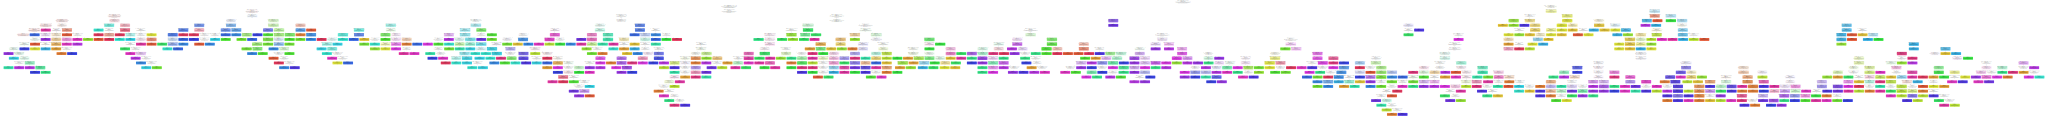

In [56]:
# Draw decision tree for modified Random Forest Classifier
import graphviz
from sklearn.tree import export_graphviz

dot = export_graphviz(clf[20],
                feature_names=X_trainval.columns,
                filled=True,
                rounded=True)
graph = graphviz.Source(dot, format='png')
graph

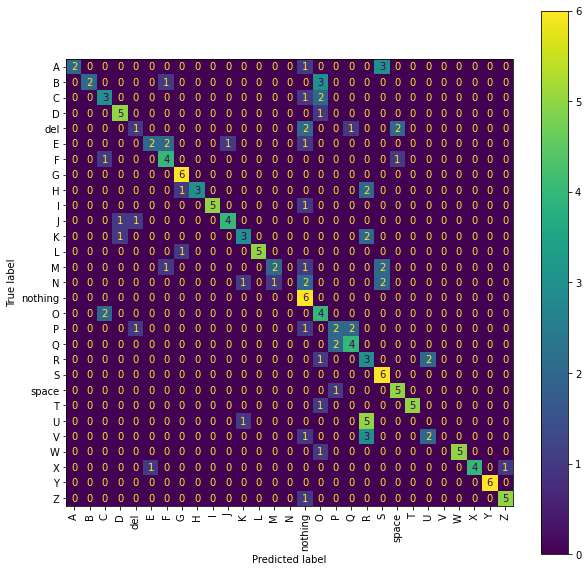

In [59]:
labels = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 
        'J', 'K', 'L', 'M', 'N', 'nothing', 'O', 'P', 'Q', 
        'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.rcParams["figure.figsize"] = (10,10)
cm_display.plot()
plt.xticks(rotation=90)
plt.show()